In [58]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [59]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i], max=L[i])
    return x


In [60]:
N_Agents = 2
in_dim = 1
batch_size = 32
n_samples = 1024
timesteps = 100
lam = 0.5
control_energy_reg = 0#1e-9 ### regularization on maximum control energy
k_max = 128
u_max = 100 # does not do anything currently
thres = 1e-3 ### softness on constraint (will penalize when this much outside of rect)


In [61]:
densties = ['custom']
regions = [
        torch.tensor([[.0, .3]]),
        torch.tensor([[.6, .9]])
        ]
weights = [.5, .5]

In [62]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)

<module 'Recursive_KAN' from 'c:\\Users\\JP\\Documents\\TU Berlin\\Master\\Code_RNN\\Recursive_kan\\Recursive_KAN.py'>

In [63]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    x = x.item()
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)


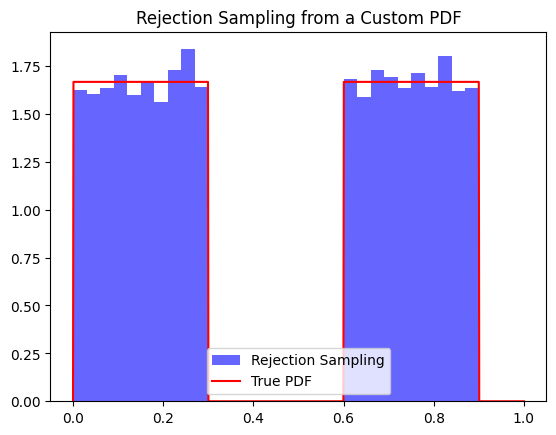

Epoch [1/150], Loss: 0.287785
Epoch [2/150], Loss: 0.182531
Epoch [3/150], Loss: 0.134075
Epoch [4/150], Loss: 0.055272
Epoch [5/150], Loss: 0.016387
Epoch [6/150], Loss: 0.008575
Epoch [7/150], Loss: 0.006940
Epoch [8/150], Loss: 0.005873
Epoch [9/150], Loss: 0.004878
Epoch [10/150], Loss: 0.004222
Epoch [11/150], Loss: 0.003494
Epoch [12/150], Loss: 0.002973
Epoch [13/150], Loss: 0.003792
Epoch [14/150], Loss: 0.003616
Epoch [15/150], Loss: 0.011612
Epoch [16/150], Loss: 0.171217
Epoch [17/150], Loss: 0.019736
Epoch [18/150], Loss: 0.006589
Epoch [19/150], Loss: 0.004458
Epoch [20/150], Loss: 0.004487
Epoch [21/150], Loss: 0.006787
Epoch [22/150], Loss: 0.003448
Epoch [23/150], Loss: 0.002759
Epoch [24/150], Loss: 0.002505
Epoch [25/150], Loss: 0.002300
Epoch [26/150], Loss: 0.002191
Epoch [27/150], Loss: 0.001952


In [64]:
models = []
for density in densties:
    criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = density,verbose = True, pdf = custom_pdf, num_samples = 10000)
    model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 256, depth = 3, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi')
    model.init_hidden(batch_size = batch_size)
    epochs = 150  # Number of epochs to train
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    train_loss = []
    test_loss = []
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0 
        for samples in range(n_samples // batch_size):
            model.init_hidden(batch_size = batch_size)
            optimizer.zero_grad()
            control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
            loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / n_samples
        train_loss.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    models.append(model)
    plt.plot(train_loss)
    plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
    plt.legend()
    plt.show()
    print("Training Complete!")

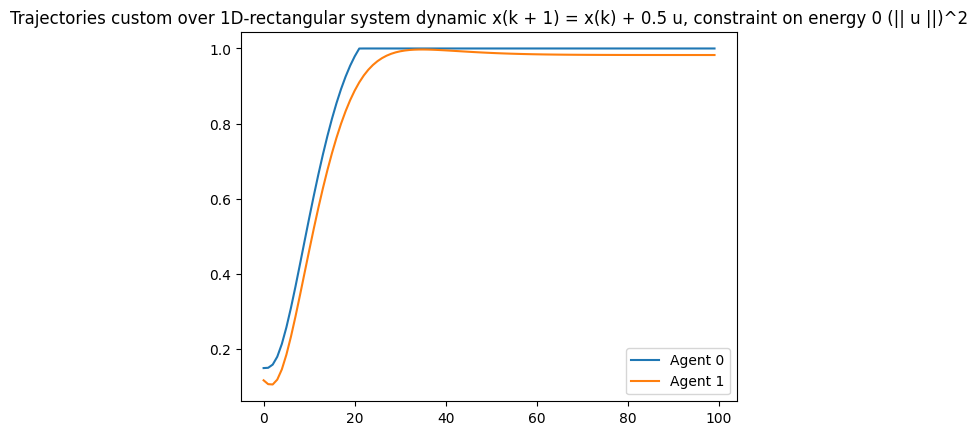

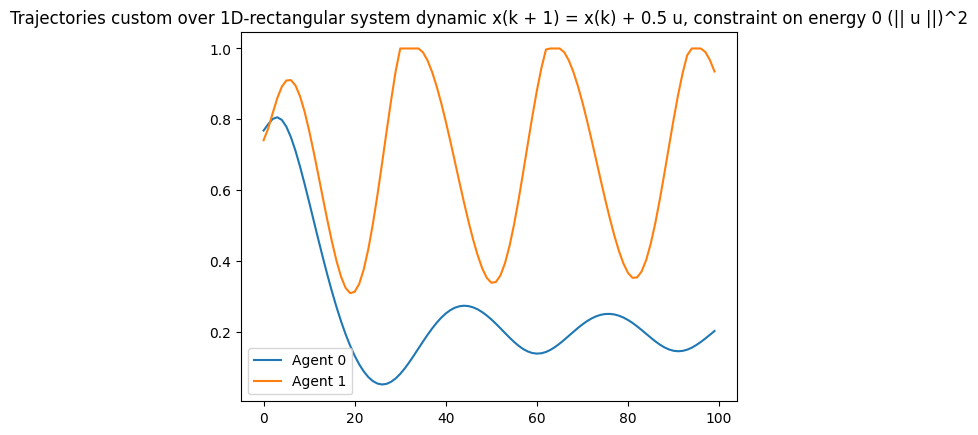

In [ ]:
#plot trajectory
for i,model in enumerate(models):
    model.eval()
    inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
    model.init_hidden(batch_size = 1)
    outs, control = model(inital_state)
    for i in range(N_Agents):
        plt.plot(outs[:,:,i,:].squeeze().detach(), label = f'Agent {i}')
    plt.title(f'Trajectories {densties[i]} over 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
    plt.legend()
    plt.show()

